### Team members:

* Swaroop Bhandary K
* Deepamsh Pandey

#### Reading the video files at the rate of 2 frame per second and saving it in the specific directory

In [ ]:
import cv2
from os import listdir

video_dir = 'videos/'
video_files = listdir(video_dir)
count_copedo = 0
count_dynaped = 0
count_igus = 0

# completed 0, 1, 2, 3, 4, 5, 7, 8, 9, 12, 16
# 1, 5, 8, 12, 16

for video_id, video in enumerate(video_files):
    print("##"*40)
    print("working on {0}".format(video))    
    
    filepath = video_dir + video
    cap = cv2.VideoCapture(filepath)
    
    start_frame = 0
    
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS)/2)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for idx in range(start_frame, n_frames, frame_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, img = cap.read()
        
        cv2.imshow('display', img)
        cv2.waitKey(50)
        
        img = cv2.resize(img, (256, 256))
        num = int(input("enter 1 for copedo, 2 for dynaped and 3 for igus: "))

        if num == 1:
            print("saved in 1")
            cv2.imwrite("images/copedo/frame_{}.jpg".format(count_copedo), img)
            count_copedo += 1
        elif num == 2:
            print("saved in 2")
            cv2.imwrite("images/dynaped/frame_{}.jpg".format(count_dynaped), img)
            count_dynaped += 1
        elif num == 3:
            print("saved in 3")
            cv2.imwrite("images/igus/frame_{}.jpg".format(count_igus), img)
            count_igus += 1
        elif num == 4:
            pass
        else:
            break
    cap.release()
cv2.destroyAllWindows()

#### Moving 30% of the data to val folder

In [ ]:
import numpy as np
import shutil

copedo = list(set(np.random.randint(0, 235, 71)))

for file_id in copedo:
    source1 = "/home/swaroop/Documents/uni_bonn/computer_vision/ss19/session_5/images/train/copedo/frame_{}.jpg".format(file_id)
    dest1 = "/home/swaroop/Documents/uni_bonn/computer_vision/ss19/session_5/images/val/copedo/frame_{}.jpg".format(file_id)
    
    source2 = "/home/swaroop/Documents/uni_bonn/computer_vision/ss19/session_5/images/train/dynaped/frame_{}.jpg".format(file_id)
    dest2 = "/home/swaroop/Documents/uni_bonn/computer_vision/ss19/session_5/images/val/dynaped/frame_{}.jpg".format(file_id)
    
    source3 = "/home/swaroop/Documents/uni_bonn/computer_vision/ss19/session_5/images/train/igus/frame_{}.jpg".format(file_id)
    dest3 = "/home/swaroop/Documents/uni_bonn/computer_vision/ss19/session_5/images/val/igus/frame_{}.jpg".format(file_id)
    
    shutil.move(source1, dest1)
    shutil.move(source2, dest2)
    shutil.move(source3, dest3)

In [13]:
import torch
import torchvision
import os
import time
import copy
import numpy as np

from torch.optim import SGD
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import resnet18
from matplotlib import pyplot as plt


torch.random.manual_seed(1)

cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.random.manual_seed(1)
    aDev = torch.device("cuda")
else:
    aDev = torch.device("cpu")

In [2]:
print(aDev)

cuda


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.3933, 0.4619, 0.3556], [0.2135, 0.2257, 0.2165])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.3933, 0.4619, 0.3556], [0.2135, 0.2257, 0.2165])
    ])
    
}

data_dir = 'images'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64,
                            shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(aDev)
                labels = labels.to(aDev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        
        inputs, labels = inputs.to(aDev), labels.to(aDev)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu()[j])

            if images_so_far == num_images:
                return

In [6]:
resnet = resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False
    
num_flts = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_flts, 10)

resnet = resnet.to(aDev)
criterion = torch.nn.CrossEntropyLoss()
optimizer_conv = SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
model_conv = train_model(resnet, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8065 Acc: 0.1860
val Loss: 1.1710 Acc: 0.3385

Epoch 1/24
----------
train Loss: 1.0479 Acc: 0.4748
val Loss: 0.8599 Acc: 0.5156

Epoch 2/24
----------
train Loss: 0.7845 Acc: 0.6415
val Loss: 0.5040 Acc: 0.9323

Epoch 3/24
----------
train Loss: 0.5341 Acc: 0.8566
val Loss: 0.3997 Acc: 0.9062

Epoch 4/24
----------
train Loss: 0.4392 Acc: 0.8973
val Loss: 0.3121 Acc: 0.9531

Epoch 5/24
----------
train Loss: 0.3652 Acc: 0.9205
val Loss: 0.2569 Acc: 0.9740

Epoch 6/24
----------
train Loss: 0.3425 Acc: 0.9225
val Loss: 0.2526 Acc: 0.9740

Epoch 7/24
----------
train Loss: 0.3350 Acc: 0.9302
val Loss: 0.2597 Acc: 0.9583

Epoch 8/24
----------
train Loss: 0.3312 Acc: 0.9244
val Loss: 0.2521 Acc: 0.9583

Epoch 9/24
----------
train Loss: 0.3363 Acc: 0.9128
val Loss: 0.2451 Acc: 0.9792

Epoch 10/24
----------
train Loss: 0.3481 Acc: 0.9225
val Loss: 0.2438 Acc: 0.9688

Epoch 11/24
----------
train Loss: 0.3062 Acc: 0.9477
val Loss: 0.2406 Acc: 0.9792

Ep

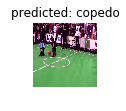

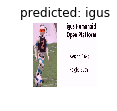

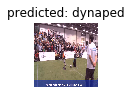

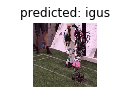

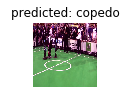

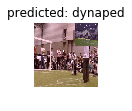

In [14]:
visualize_model(model_conv)

In [16]:
torch.save(model_conv.state_dict(), "resnet_rob_model.th")